# Fairness Metrics

Welcome here you will be introduced to and gain experience in using some fairness metrics. You will be expected create an ML model to predict an outcome, then you  will use a variety of formalised fairness metrics to gain an intuition of their precise meaning whilst offering an opportunity to reflect on their strengths and weaknesses. 


<h2>Learning Objectives:</h2>

- Gain experience in implementing and using fairness metrics
- To investigate gaining insights into the fairness of data-driven decision making algorithms 
- To critically appraise varied metrics in their use and limitations in measuring fairness

<h3>Fairness Metrics  - Group Fairness</h3>

In this lab we will focus on a small number of fairness metrics and test the effectiveness of a fairness through unawareness strategy.

- Demographic Parity 
- Equalised Odds [1]
- Equal Opportunity [1]
- Fairness Through Unawareness


<center><img src="images/fairness.png" style="width:500px;"><centre>
<caption><center> <i><b>Figure 1:</b> Brief history of Fairness in Machine Learning.</i>  </center></caption>
    
[Image source](https://towardsdatascience.com/a-tutorial-on-fairness-in-machine-learning-3ff8ba1040cb)

[1] M. Hardt, E. Price, and N. Srebro, “Equality of Opportunity in Supervised Learning,” 2016.
    
Run the following cell to import libraries needed for this workbook

In [1]:
import sys
import os
from platform import python_version 

#------------- Load in some helpful packages we will use for the lab -------------------------

import numpy as np # linear algebra
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve


from sklearn.model_selection import train_test_split # randomly split data into test and train
from sklearn.ensemble import RandomForestClassifier # import classifier from sklearn 
from sklearn.neural_network import MLPClassifier  # import classifier from sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn import tree
from sklearn.preprocessing import StandardScaler, LabelEncoder


#------------- Print versions an paths for potencial debugging -------------------------

print('Python version:', python_version()) # print the version of python the script is using
print('Python path:', sys.executable) # print the path for the python executable the script is using
print('Working Directory:', os.getcwd()) # print the current working directory 


Python version: 3.8.5
Python path: /Users/Andy/opt/anaconda3/bin/python
Working Directory: /Users/Andy/Developer/Swansea Uni/CDT/Semester 2/CSCM21 - Abuses, Biases and Blessing of Data/CSCM21 - Abuses, Biases and Blessing of Data/Labs/Lab 4


# 1. Build classifier to predict $\hat{Y}$

In the first section of this work book you will load some data bulid a model to predcit an out come and later on you will test this model for fairness.

## 1.1 Load Data Set

In this section we will load a data set on which to apply our various fairness metrics. The data we are loading is the German Credit data it has 20 Attributes (7 numerical, 13 categorical). It contains various information about each applicant that is applying for a loan for example: salary paid in, years in employment, years in current address, loan amount etc. You can read about all the attributes in the data folder from the lab download in the data folder there is a word file called 'german_data_description.doc'.

Couple of things to note: 

- The original data set comes with a cost matrix (for the loan decision). In this lab we simplify this to a simple ground truth label of the loan should be issued or not $Y = y, y \in {0,1}$.
   - This data is in an additional column in the data set named `classification`.
- The attributes contain explicit information on the sex and marital status of the loan applicant, in an attribute named `statussex`.
    - At the end of section 1. in the workbook we will create a disaggregate attribute which contains sex only, in order that we can apply fairness metric across this protected attribute
    - In Section 3. we will investigate the impact of removing this explicit sex information from the attributes of the data.

Run the cell below to load the data and convert the ground truth column

In [2]:
names = ['existingchecking', 'duration', 'credithistory', 'purpose', 'creditamount', 
         'savings', 'employmentsince', 'installmentrate', 'statussex', 'otherdebtors', 
         'residencesince', 'property', 'age', 'otherinstallmentplans', 'housing', 
         'existingcredits', 'job', 'peopleliable', 'telephone', 'foreignworker', 'classification']

data = pd.read_csv("data/german.data", delimiter=' ', names = names )

data.classification.replace([1,2], [1,0], inplace=True)

## 1.2 Pre-process data

Run the following cell to pre-process the data ready for training a classification model, this includes:

- normalising the numerical values
- converting categorical values to numbers (needed for some classifiers)
- save the data in new dataframe `clean_data`.


In [3]:
#numerical variables labels
numvars = ['creditamount', 'duration', 'installmentrate', 'residencesince', 'age', 
           'existingcredits', 'peopleliable', 'classification']

# Normilisation
numdata_std = pd.DataFrame(StandardScaler().fit_transform(data[numvars].drop(['classification'], axis=1)))

from collections import defaultdict

#categorical variables labels
catvars = ['existingchecking', 'credithistory', 'purpose', 'savings', 'employmentsince',
           'statussex', 'otherdebtors', 'property', 'otherinstallmentplans', 'housing', 'job', 
           'telephone', 'foreignworker']

d = defaultdict(LabelEncoder)

# Encoding the variable
lecatdata = data[catvars].apply(lambda x: d[x.name].fit_transform(x))

#combine data into one clean data set
data_clean = pd.concat([data[numvars], lecatdata], axis = 1)

**Your tasks are to:**

- print out the shape of the clean data
- view the clean data 

In [4]:
#### START CODE ####

#1. print shape of the clean data
print(data_clean.shape)

#2. view the data
print(data_clean)

#### END CODE #####

(1000, 21)
     creditamount  duration  installmentrate  residencesince  age  \
0            1169         6                4               4   67   
1            5951        48                2               2   22   
2            2096        12                2               3   49   
3            7882        42                2               4   45   
4            4870        24                3               4   53   
..            ...       ...              ...             ...  ...   
995          1736        12                3               4   31   
996          3857        30                4               4   40   
997           804        12                4               4   38   
998          1845        45                4               4   23   
999          4576        45                3               4   27   

     existingcredits  peopleliable  classification  existingchecking  \
0                  2             1               1                 0   
1               

## 1.3 Create Train and Test Data Sets

run the following cell to create the test and train data sets for both $X$ input attributes and $Y$ output labels:

- `X_train_clean`
- `X_test_clean`
- `y_train_clean`
- `y_test_clean`

**Your task is to:**

- print the list of columns contained in `X_train_clean`
  - dataframe column names can be printed by using `df.keys()`. [Link to help](https://pandas-docs.github.io/pandas-docs-travis/reference/api/pandas.DataFrame.keys.html)

In [5]:
X_clean = data_clean.drop('classification', axis=1)
y_clean = data_clean['classification']
X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(X_clean, y_clean, test_size=0.2, random_state=1)

class_names = ['Loan Refused (negative)', 'Loan Granted (positive)'] # used later to lable confusion matrices

#### START CODE ####

print(X_train_clean.keys())
#### END CODE #####

Index(['creditamount', 'duration', 'installmentrate', 'residencesince', 'age',
       'existingcredits', 'peopleliable', 'existingchecking', 'credithistory',
       'purpose', 'savings', 'employmentsince', 'statussex', 'otherdebtors',
       'property', 'otherinstallmentplans', 'housing', 'job', 'telephone',
       'foreignworker'],
      dtype='object')



##### **Expected Output**:

<table>
    <tr>
        <td>
            Index
        </td>
        <td>
            ['creditamount', 'duration', 'installmentrate', 'residencesince', 'age',
       'existingcredits', 'peopleliable', 'existingchecking', 'credithistory',
       'purpose', 'savings', 'employmentsince', 'statussex', 'otherdebtors',
       'property', 'otherinstallmentplans', 'housing', 'job', 'telephone',
       'foreignworker']
        </td>
    </tr>
</table>



## 1.4 Train and Test Classifier

In this section you will need to train classifier and run the classifier on the test data to create the predicted labels.

Run the cell below.

In [6]:
model = RandomForestClassifier(n_estimators=100, random_state=1, max_depth=5).fit(X_train_clean, y_train_clean)

pred_val_y = model.predict(X_test_clean)

## 1.5 Plot the Results of the Classifier

In this section you will plot the results of the classifiers results on weather to issue loans to the applicants.

**Your tasks are to:**

- calculate and print the classifier accuracy
    - use `accuracy_score()` imported from `sklearn.metrics` with two parameters first $Y$, second $\hat{Y}$. [Link to help](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)
- calculate and print the classifier f1 score
    - use `f1_score()` imported from `sklearn.metrics` with two parameters first $Y$, second $\hat{Y}$. [Link to help](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)


In [7]:
### START CODE #####

#1. calc acc
acc = accuracy_score(y_test_clean, pred_val_y)

#2. calc f1
f1 = f1_score(y_test_clean, pred_val_y)

### END CODE #####

print('Model accuracy = ', acc)
print('Model f1 score = ', f1)

Model accuracy =  0.755
Model f1 score =  0.848297213622291


##### **Expected Output**:

<table>
    <tr>
        <td>
            Model accuracy
        </td>
        <td>
            0.755
        </td>
    </tr>
    <tr>
        <td>
            Model f1 score
        </td>
        <td>
            0.848297213622291
        </td>
    </tr>
</table>

Run the code in the two cells below to plot a confusion matrix and reciever operating curve (ROC) of the model performance.

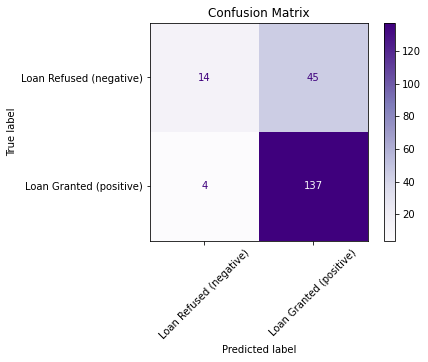

In [8]:
cm = confusion_matrix(y_test_clean, pred_val_y, labels=model.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = class_names)
disp = disp.plot(cmap = 'Purples', values_format = '.0f')
plt.xticks(rotation = 45)
plt.title('Confusion Matrix');
plt.show()

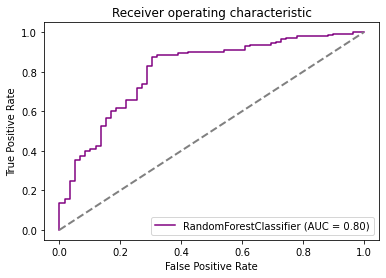

In [9]:
metrics.plot_roc_curve(model, X_test_clean, y_test_clean, color='purple')

plt.plot([0, 1], [0, 1], color = 'grey', lw = 2, linestyle = '--')
plt.title('Receiver operating characteristic')
plt.show() 

### 1.5.1 Classifier Results by Sex

In this section we will create a sex code column in the data to assess the performance of the classifier for males and females, since we have already passed the classifier over all the test examples here we will add the classifier predictions, $\hat{Y}$, and sex code, $A$, columns to a dataframe along with the ground truth label $Y$ and input attributes $X$. All this data will be saved in a dataframe named `test_results`.

**Your tasks are to:**

- create variables that map to the column names in the dataframe
    - sensitive attribute $A$,  `A`
    - predicted outcome $\hat{Y}$,  `Y_hat`
    - actual outcome $Y$,  `Y`
- view the dataframe `test_results`.

**Hint** you may need to read the code in the cell and view the dataframe to identify the column names to map the variables.

In [10]:
test_results = X_test_clean.merge(y_test_clean, left_index=True, right_index=True)
test_results['pred_Y'] = pred_val_y

def label_sex(row):
    if row['statussex'] == 0 or row['statussex'] == 2 or row['statussex'] == 3:
        return(1)
    if row['statussex'] == 1:
        return(0) 

# crete new coloumn to denote sex in results
test_results['Sex_code'] = test_results.apply (lambda row: label_sex(row), axis=1)

#### START CODE 

#1. set varible to column names that 
A = 'Sex_code'
Y_hat = 'pred_Y'
Y = 'classification'

#2. view dataframe
print(test_results)

### END CODE ####

     creditamount  duration  installmentrate  residencesince  age  \
507          6850        15                1               2   34   
818         15857        36                2               3   43   
452          2759        12                2               4   34   
368          3446        36                4               2   42   
242          4605        48                3               4   24   
..            ...       ...              ...             ...  ...   
430          3448         5                1               4   74   
874          3590        12                2               2   29   
550           996        12                4               4   23   
608          2051        18                4               1   33   
207          1424        12                4               3   26   

     existingcredits  peopleliable  existingchecking  credithistory  purpose  \
507                1             2                 1              1        0   
818        

### 1.5.2 Investigating the output.

In this section you will investigate the output table this skills will help later in calculating Fairness metrics by counting True positives, False Negatives, number of males females etc. To do this below is a a reminder on dataframes is illustrated on figure 2. Furthermore you can access specific columns and rows in the dataframe at any one time. For example:

- you can count the number of rows in a dataframe using `len(df)`
- you can view only rows with specific attributes using `df[(df['Sex_code'] == 1)]` 
    - combine the above to count number of males.
    - you can logically combine indexing for example male and existing credits is two. 
        - `test_results[(test_results['Sex_code'] == 1) & (test_results['existingcredits'] == 2)]`
- you can view the data in the 'creditamount' column only `df['creditamount']`


<center><img src="images/finallpandas.png" style="width:500px;"></center>
<caption><center><i> <b>Figure 2:</b> Pandas DataFrame  is two-dimensional tabular data structure with labeled axes and consists of three principal components, the <font color='purple'><b>data</b></font>, <font color='orange'><b>rows</b></font>, and <font color='blue'><b>columns</b></font>.</i> </center></caption>

**Optional information** see data geeks for simple explanation and source of Figure 2 https://www.geeksforgeeks.org/python-pandas-dataframe/#. Alternatively you can visit the official Pandas DataFrame usage page https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html


**Your task is to:**


- Count the number of males in the test set
- Count the number of females in the test set that have one exiting loan
- View the data in three specific columns in `test_results` dataframe
    - sensitive attribute $A$,  `A`
    - predicted outcome $\hat{Y}$,  `Y_hat`
    - actual outcome $Y$,  `Y`


**Note** Where appropriate use your variables not column names.

In [11]:
### START CODE ####

#1.count males
num_males = len(test_results[(test_results['Sex_code'] == 1)])

print('num_males',num_males)


#2. count female with one exsiting credit

num_female_credit = len(test_results[(test_results['Sex_code'] == 0) & (test_results['existingcredits'] == 1)])

print('num_female_credit',num_female_credit)


#3. edit code to view different data columns
print(test_results['creditamount'])


### END CODE ###

num_males 147
num_female_credit 36
507     6850
818    15857
452     2759
368     3446
242     4605
       ...  
430     3448
874     3590
550      996
608     2051
207     1424
Name: creditamount, Length: 200, dtype: int64


### 1.5.2 Create data frames for male and females

In this section you will separate data frames for male and females to make the generation of the confusion matrices and ROC plots more simple. 


**Your task is to:**

- Calculate accuracy for males only
- Calculate f1 score for males only

**Note** when you run the code note the new names of the male and female only data frames. Also note how we can reference male only data using `test_results[(test_results[A] == 1)]` understanding this notation this will come in helpful later when calculating fairness metrics.

In [12]:
male_test_results = test_results[(test_results[A] == 1)]

female_test_results = test_results[(test_results[A] == 0)]

male_X_clean = male_test_results.drop(['classification', 'pred_Y','Sex_code'], axis=1)

female_X_clean = female_test_results.drop(['classification', 'pred_Y','Sex_code'], axis=1)

### START CODE ###

#1. calc male acc
male_accuracy = accuracy_score(male_test_results[Y], male_test_results[Y_hat])

#2. calc male f1
male_f1 = f1_score(male_test_results[Y], male_test_results[Y_hat])

#### END CODE ####

print('Model accuracy (males) = ', male_accuracy)
print('Model f1 score (males) = ', male_f1)

Model accuracy (males) =  0.7755102040816326
Model f1 score (males) =  0.8630705394190872


##### **Expected Output**:

<table>
    <tr>
        <td>
            Model accuracy (males)
        </td>
        <td>
            0.7755102040816326
        </td>
    </tr>
    <tr>
        <td>
            Model f1 score (males)
        </td>
        <td>
            0.8630705394190872
        </td>
    </tr>
</table>

**Your task is to:**

- Calculate the male only confution matrix, `cm`
    - reference the code used in section 1.5.


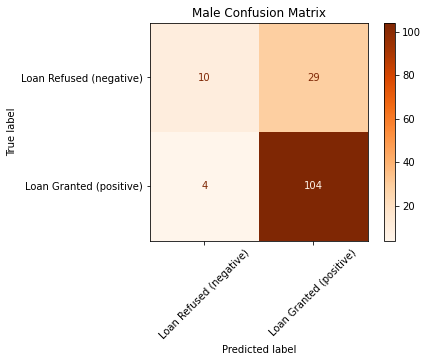

In [13]:
#### START CODE ###

cm = confusion_matrix(male_test_results[Y], male_test_results[Y_hat], labels=model.classes_)

### END CODE ###

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp = disp.plot(cmap='Oranges',values_format = '.0f')
plt.xticks(rotation=45)
plt.title('Male Confusion Matrix');
plt.show()

##### **Expected Output**:

<table>
    <tr>
        <td>
            Male Confusion Matrix
        </td>
        <td>
            <img src="images/male_cm.png" style="width:250px;">
        </td>
    </tr>
</table>

**Your task is to:**

- Plot the male only ROC
    - reference the code used in section 1.5.

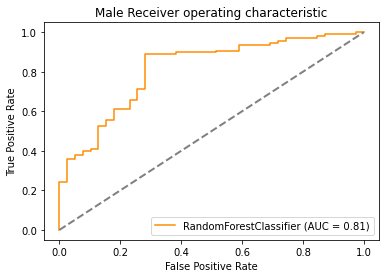

In [14]:
#### START CODE ###

metrics.plot_roc_curve(model, male_X_clean, male_test_results[Y], color='darkorange')

#### END CODE ###

plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.title('Male Receiver operating characteristic')
plt.show()

##### **Expected Output**:

<table>
    <tr>
        <td>
            Male Receiver operating characteristic
        </td>
        <td>
            <img src="images/male_roc.png" style="width:250px;">
        </td>
    </tr>
</table>

**Your task is to:**

- Calculate accuracy for females only
- Calculate f1 score for females only

In [15]:
female_accuracy = accuracy_score(female_test_results[Y], female_test_results[Y_hat])
female_f1 = f1_score(female_test_results[Y], female_test_results[Y_hat])
print('Model accuracy (females) = ', female_accuracy)
print('Model f1 score (females) =', female_f1)

Model accuracy (females) =  0.6981132075471698
Model f1 score (females) = 0.8048780487804877


##### **Expected Output**:

<table>
    <tr>
        <td>
            Model accuracy (females)
        </td>
        <td>
            0.6981132075471698
        </td>
    </tr>
    <tr>
        <td>
            Model f1 score (females)
        </td>
        <td>
            0.8048780487804877
        </td>
    </tr>
</table>

**Your task is to:**

- Calculate the female only confusion matrix, `cm`
    - reference the code used in section 1.5.


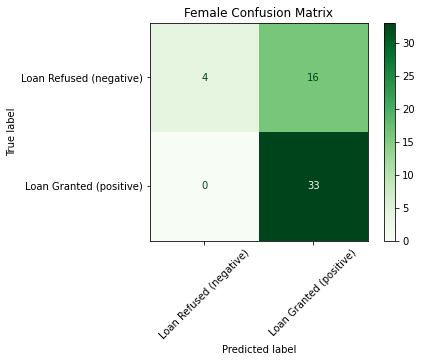

In [16]:
### START CODE ####

cm = confusion_matrix(female_test_results[Y], female_test_results[Y_hat], labels=model.classes_)

### END CODE ###

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp = disp.plot(cmap='Greens',values_format = '.0f')
plt.xticks(rotation=45)
plt.title('Female Confusion Matrix');
plt.show()

##### **Expected Output**:

<table>
    <tr>
        <td>
            Female Confusion Matrix
        </td>
        <td>
            <img src="images/female_cm.png" style="width:250px;">
        </td>
    </tr>
</table>

**Your task is to:**
 
- plot the female only ROC

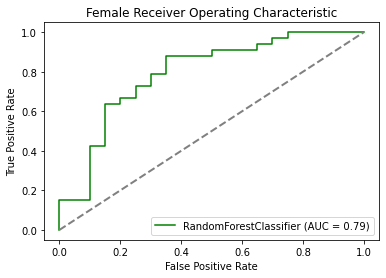

In [17]:
#### START CODE #####

metrics.plot_roc_curve(model, female_X_clean, female_test_results[Y], color='green')

#### END CODE ####
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.title('Female Receiver Operating Characteristic')
plt.show() 

##### **Expected Output**:

<table>
    <tr>
        <td>
            Female Receiver Operating Characteristic
        </td>
        <td>
            <img src="images/female_roc.png" style="width:250px;">
        </td>
    </tr>
</table>

# 2. Fairness Metrics

In this section you will implement and calculate various fairness metrics and apply them to the model created in Section 1. In this case the protected characteristic we will use will be sex (male, female). 


## 2.1 Demographic Parity

A common conception of non-discrimination is demographic parity requires that a decision - such as accepting or denying a loan application — be independent of the protected attribute. In the case of a binary decision $\hat{Y} \in {0,1}$ and a binary protected attribute $A \in {0,1}$, this constraint can be formalized by asking that:

$$ Pr(\hat{Y} = 1 | A = 0) = Pr(\hat{Y} = 1| A = 1) $$

In other words, membership in a protected class should have no correlation with the decision. Through its various equivalent formalizations this idea appears in numerous papers. 

**Your tasks are to:**

- Calculate the total number of tests, `total_tests`
    - You need this to calculate probability, divide condition count by total number of tests.
- Calculate `Pr_male_CP` the probability of a Condition Positive for a Male , $Pr(\hat{Y} = 1| A = 1)$
- Calculate `Pr_female_CP` the probability of a Condition Positive for a Female, $Pr(\hat{Y} = 1 | A = 0)$
- Calculate `male_CN` the probability of a Condition Negative for a Male , $Pr(\hat{Y} = 0| A = 1)$
- Calculate `female_CN` the probability of a Condition Negative for a Female, $Pr(\hat{Y} = 0 | A = 0)$
- Write a test compares if these results are equal for males and females under demographic parity, set the output to: True or False.
  - conditions positive, `demo_equal_CP`
  - condition negative, `demo_equal_CN`
  - if both positive and negative is true then this is demographic parity, `demo_parity`
  

In [18]:
### START CODE ###
# 1. calc total tests
total_tests = len(test_results)

#2. calc male condition positive
male_CP = len(test_results[(test_results[A] == 1) & (test_results[Y_hat] == 1)])
Pr_male_CP = male_CP/total_tests

#3. calc female condition positive
female_CP = len(test_results[(test_results[A] == 0)  & (test_results[Y_hat] == 1)])
Pr_female_CP = female_CP/total_tests

#4. calc male condition negative
male_CN = len(test_results[(test_results[A] == 1) & (test_results[Y_hat] == 0)])
Pr_male_CN = male_CN/total_tests

#5. calc female condition negative
female_CN = len(test_results[(test_results[A] == 0) & (test_results[Y_hat] == 0)])
Pr_female_CN = female_CN / total_tests

#6. calc equality tests for both postive and negative condition
demo_equal_CP = male_CP == female_CP
demo_equal_CN = male_CN == female_CN

#7. test for demogrpahic parity (when both equal_CP and equal_CN are True)
demo_parity = demo_equal_CP & demo_equal_CN


### END CODE ###

print('Male Condition Positive probability = ',Pr_male_CP)
print('Female Condition Positive probability = ',Pr_female_CP)
print('Male Condition Negative probability = ',Pr_male_CN)
print('Female Condition Negative probability = ',Pr_female_CN)

print('Demographic Parity for Condition Positive is:',demo_equal_CP)
print('Demographic Parity for Condition Negative is:',demo_equal_CN)
print('Demographic Parity is:',demo_parity)



Male Condition Positive probability =  0.665
Female Condition Positive probability =  0.245
Male Condition Negative probability =  0.07
Female Condition Negative probability =  0.02
Demographic Parity for Condition Positive is: False
Demographic Parity for Condition Negative is: False
Demographic Parity is: False


##### **Expected Output**:

<table>
    <tr>
        <td>
            Male Condition Positive probability
        </td>
        <td>
            0.665
        </td>
    </tr>
    <tr>
        <td>
            Female Condition Positive probability
        </td>
        <td>
            0.245
        </td>
    </tr>
    <tr>
        <td>
            Male Condition Negative probability
        </td>
        <td>
            0.07
        </td>
    </tr>
    <tr>
        <td>
            Female Condition Negative probability
        </td>
        <td>
            0.02
        </td>
    </tr>
    <tr>
        <td>
            Demographic Parity for Condition Positive
        </td>
        <td>
            False
        </td>
    </tr>
    <tr>
        <td>
            Demographic Parity for Condition Negative
        </td>
        <td>
            False
        </td>
    </tr>
    <tr>
        <td>
            Demographic Parity
        </td>
        <td>
            False
        </td>
    </tr>
</table>



### 2.1.1 Common Relaxation Techniques for Demographic Parity

There are two common relaxations of the strict definition of Demographic Parity. First we are often more interested in the positive condition in this case we need only to achieve parity on $\hat{Y} =1$. Second, from the US Civil Rights act of 1964 we have legal guidance with which we can relax the formal constraint of being exactly equal. The four-fifths or 80% rule is described by the guidelines as <i>“a selection rate for any race, sex, or ethnic group which is less than four-fifths (or 80%) of the rate for the group with the highest rate will generally be regarded by the Federal enforcement agencies as evidence of adverse impact, while a greater than four-fifths rate will generally not be regarded by Federal enforcement agencies as evidence of adverse impact."</i> Therefore we can re-define the constraint in the test (assume $A=1$ is the advantaged group) to:

$$ \frac{Pr(\hat{Y}=1, A=0)}{Pr(\hat{Y}=1, A=1)} \geq 1- \epsilon $$

**Your task is to:**

- Implement a function to test a relaxed 'equal to', `Relax_equal()`
  - Complete the function input parameters - use function description to help.
    - `epsilon` , `high_group`, `low_group`
  - calculate ratio of left hand side of equation, `relax_ratio`.
  - create a comparative test and output True or False.
  - return result of the test
  

In [19]:
### START CODE ###

#1. complete the function input parameters
def Relax_equal(epsilon , high_group, low_group):
    '''
    This function tests for a relaxed definition of 'equal to' and returns True or False
    
    Input:
    epsilon - a number to represent percentile within which the callsifer need to perform on the lower group in comparison to the higher group
    high_group - the performance metric of the classifer on the higher (advantaged) performing group
    low_group - the performance metric of the classifer on the lower (disadvantaged) performing group
    
    Output:
    relax_equal_to - Boolean state if 'equal to' met, True or False
    '''

    #2. calc demo ratio
    relax_ratio = low_group/high_group
    
    ### END CODE ###
    
    print('Ratio ',relax_ratio)
    if relax_ratio > 1:
        print('Error: Ratio (left of eqaution) grater than one = ', relax_ratio)
        print('Ensure that the higher performing group is passed first in the parameter list, then lower performing group')
        return(None)  # NOTE None should remain in this line.

     ### START CODE ###
    
    #3. write relaxed Demogrpahic parity test
    relax_equal_to = relax_ratio >= 1-epsilon
    
    
    #4. return test result
    return(relax_equal_to)

### END CODE ###


Test your function by running the code below this tests your function by displaying the result for the four cases listed below:

- Case 1 where the classifier offers loans to 80% of men and 76% of women who apply. 
- Case 2 where the classifier offers loans to 88% of men and 73% of women who apply. 
- Case 3 where the classifier offers loans to 65% of men and 71% of women who apply.
- Case 4 where the classifier offers loans to 54% of men and 68% of women who apply.

Specifically we pass the parameter to check to see if the classifier performance for the lower group is within 10% of the higher group.

In [20]:
print('Case 1 demographic parity = ', Relax_equal(0.1 , 0.8, 0.76) )
print('Case 2 demographic parity = ', Relax_equal(0.1 , 0.88, 0.73) )
print('Case 3 demographic parity = ', Relax_equal(0.1 , 0.71, 0.65) )
print('Case 4 demographic parity = ', Relax_equal(0.1 , 0.68, 0.54) )

Ratio  0.95
Case 1 demographic parity =  True
Ratio  0.8295454545454545
Case 2 demographic parity =  False
Ratio  0.915492957746479
Case 3 demographic parity =  True
Ratio  0.7941176470588235
Case 4 demographic parity =  False


##### **Expected Output**:

<table>
    <tr>
        <td>
            Ratio
        </td>
        <td>
            0.95
        </td>
        <td>
            Case 1 demographic parity
        </td>
        <td>
            True
        </td>
    </tr>
    <tr>
        <td>
            Ratio
        </td>
        <td>
            0.8295454545454545
        </td>
        <td>
            Case 2 demographic parity
        </td>
        <td>
            False
        </td>
    </tr>
    <tr>
        <td>
            Ratio
        </td>
        <td>
            0.915492957746479
        </td>
        <td>
            Case 3 demographic parity
        </td>
        <td>
            True
        </td>
    </tr>
    <tr>
        <td>
            Ratio 
        </td>
        <td>
            0.7941176470588235
        </td>
        <td>
            Case 4 demographic parity
        </td>
        <td>
            False
        </td>
    </tr>
</table>  

In the following section test the model for Demographic fairness by calling the function you have just created `Relax_equal()`.

**Your tasks are to:**

- set $\epsilon$ to the correct value, according to the four-fifths rule.
- call your function sending condition positive data for males and females. 
- print out the result of the test.

In [21]:
### START CODE ###

#1. enter value for epsilon
epsilon = 0.2

#2. call function
test_result = Relax_equal(epsilon, male_CP, female_CP)

#3. print result of test
print('Demographic parity =', test_result)
#### END CODE #####

Ratio  0.3684210526315789
Demographic parity = False


##### **Expected Output**:

<table>
    <tr>
        <td>
            Ratio
        </td>
        <td>
            0.3684210526315789
        </td>
    </tr>    
    <tr>
        <td>
            Demographic parity
        </td>
        <td>
            False
        </td>
    </tr>
</table> 


### 2.1.2 Problems with Demographic Parity

There are a number of key downsides to demographic parity:  

- First it permits that we accept qualified applicants in the demographic $A = 0$, but unqualified individuals in $A = 1$, so long as the percentages of acceptance match. This behavior can arise naturally, when there is little or no training data available within $A = 1$. 
- Second, demographic parity can cripple the utility (classification performance). Just imagine the common scenario in which the target variable $Y$ — whether an individual actually defaults or not — is correlated with $A$. 
  - In this case demographic parity would not allow the ideal predictor $\hat{Y} = Y$.

## 2.2 Equal Odds


From the originating paper [1] for <b>Equalized odds</b>, we say that a predictor $\hat{Y}$ satisfies equalized odds with respect to protected attribute $A$ and outcome $Y$, if $\hat{Y}$ and $A$ are independent conditional on $Y$.


$$ Pr(\hat{Y}= 1 | A = 0,Y = y) = Pr(\hat{Y}= 1 | A = 1,Y = y), y \in {0,1} $$


For the outcome $y = 1$, the constraint requires that $\hat{Y}$ has equal true positive rates across the definition aligns nicely with the central goal of building highly accurate classifiers, since $\hat{Y} = Y$ is always an acceptable solution. Equalised odds also expects an equal true negative rate across all demographics for $y = 0$. Equalized odds enforces that the accuracy for both these metrics is equally high in all demographics, punishing models that perform well only on the majority.


**Your tasks are to:**

- Calculate equal positive odds
    - Calculate `male_pos_odds` positive odds for a Male , $Pr(\hat{Y} = 1 | A = 1,Y = 1))$
        - Count True Positives for Male
        - Divide by Condition positive for male, `male_CP` 
    - Calculate `female_pos_odds` positive odds for a Female, $Pr(\hat{Y}= 1 | A = 0,Y = 1)$
        - Count True Positives for Female
        - Divide by Condition positive for Female, `female_CP`
- Calculate equal negative odds
    - Calculate `male_pos_odds` negative odds for a Male , $Pr(\hat{Y} = 0 | A = 1,Y = 0))$
        - Count True negatives for Male
        - Divide by condition negative for male, `male_CN`
    - Calculate `female_pos_odds` negative odds for a Female, $Pr(\hat{Y}= 0 | A = 0,Y = 0)$
         - Count True negatives for Female
        - Divide by condition negative for Female, `female_CN`
- Write a test compares if these results are equal for males and females under equal odds, set the output to: True or False.
  - conditions positive, `equal_pos_odds`
  - condition negative, `equal_neg_odds`
  - if both positive and negative is true then this is equal odds, `equal_odds`



In [22]:
#### START CODE ####

#1. Calc postive odds for male
male_TP = len(test_results[(test_results[A] == 1) & (test_results[Y] == 1) & (test_results[Y_hat] == 1)])
male_pos_odds = male_TP/male_CP


#2. Calc postive odds for female
female_TP = len(test_results[(test_results['Sex_code'] == 0) & (test_results[Y] == 1) & (test_results['pred_Y'] == 1)])
female_pos_odds = female_TP/female_CP


#3. Calc negative odds for male
male_TN = len(test_results[(test_results[A] == 1) & (test_results[Y] == 0) & (test_results[Y_hat] == 0)])
male_neg_odds =male_TN/male_CN


#.4 Calc negative odds for females
female_TN = len(test_results[(test_results[A] == 0) & (test_results[Y] == 0) & (test_results[Y_hat] == 0)])
female_neg_odds =female_TN/female_CN

#5. Tests for odds
equal_pos_odds = male_pos_odds == female_pos_odds
equal_neg_odds = male_neg_odds == female_neg_odds
equal_odds = equal_pos_odds & equal_neg_odds


#### END CODE ####


print('male_pos_odds',male_pos_odds)
print('female_pos_odds',female_pos_odds)
print('male_neg_odd',male_neg_odds)
print('female_neg_odd',female_neg_odds)

print('Equal Positive Odds = ',equal_pos_odds)
print('Equal Negative Odds = ',equal_neg_odds)
print('Equal Odds = ',equal_odds)


male_pos_odds 0.7819548872180451
female_pos_odds 0.673469387755102
male_neg_odd 0.7142857142857143
female_neg_odd 1.0
Equal Positive Odds =  False
Equal Negative Odds =  False
Equal Odds =  False


##### **Expected Output**:

<table>
    <tr>
        <td>
            Demale_pos_odds
        </td>
        <td>
            0.7819548872180451
        </td>
    </tr>    
    <tr>
        <td>
            female_pos_odds
        </td>
        <td>
            0.673469387755102
        </td>
    </tr>
    <tr>
        <td>
            male_neg_odd
        </td>
        <td>
            0.7142857142857143
        </td>
    </tr>
    <tr>
        <td>
            female_neg_odd
        </td>
        <td>
            1.0
        </td>
    </tr>
    <tr>
        <td>
            Equal Positive Odds
        </td>
        <td>
            False
        </td>
    </tr>
    <tr>
        <td>
            Equal Negative Odds 
        </td>
        <td>
            False
        </td>
    </tr>
    <tr>
        <td>
            Equal Odds 
        </td>
        <td>
            False
        </td>
    </tr>
</table> 


## 2.3 Equal Opportunity

In the binary case, we often think of the outcome $Y = 1$ as the “advantaged” outcome, such as “not defaulting on a loan”, “admission to a college” or “receiving a promotion”. A possible relaxation of equalized odds is to require non-discrimination only within the “advantaged” out- come group. That is, to require that people who pay back their loan, have an equal opportunity of getting the loan in the first place (without specifying any requirement for those that will ultimately default). This leads to a relaxation the equal odds notion that is called “equal opportunity”.

<b>Equal opportunity</b>, we say that a binary predictor $\hat{Y}$ satisfies equal opportunity with respect to A and Y if:

$$ Pr(\hat{Y} = 1 | A = 0,Y = 1) = Pr(\hat{Y}= 1 | A = 1,Y = 1) $$

We can also apply the four-fifths rule here too to further relax the test:

$$ \frac{Pr(\hat{Y} = 1 | A = 0,Y = 1)}{Pr(\hat{Y}= 1 | A = 1,Y = 1)} \geq 1- \epsilon $$

**Your task is too:**

- calculate equal opportunity
  - note we have already calculated the male and female equal opportunity odds since these are the positive condition odds from equal opportunity.
- test for equal opportunity under four fifths rule
  - you can use the function you build earlier and pass it the new metrics


In [23]:
#### START CODE ####

equal_opp = Relax_equal(epsilon, male_pos_odds,female_pos_odds)

### END CODE ####
print('equal oppertuniy under four-fiths =', equal_opp)

Ratio  0.8612637362637363
equal oppertuniy under four-fiths = True


##### **Expected Output**:

<table>
    <tr>
        <td>
            Ratio
        </td>
        <td>
            0.8612637362637363
        </td>
    </tr>
    <tr> 
        <td>
            equal opportunity (four-fifths)
        </td>
        <td>
            True
        </td>
    </tr>
</table> 


Since equal opportunity is met under the relaxed four-fifths rule its and an interesting question to ask ourselves would our model mass the equal odds test under this condition.

**Your task is to:**

- using the `Relax_equal()` function test to see of the model meets full equal odds

In [24]:
#### START CODE ####

equal_neg = Relax_equal(epsilon, female_neg_odds, male_neg_odds)

### END CODE ####

print('equal_oppertuniy under four-fiths =', equal_neg)

Ratio  0.7142857142857143
equal_oppertuniy under four-fiths = False


##### **Expected Output**:

<table>
    <tr>
        <td>
            Ratio
        </td>
        <td>
            0.7142857142857143
        </td>
    </tr>
    <tr> 
        <td>
            equal opportunity (four-fifths)
        </td>
        <td>
            False
        </td>
    </tr>
</table> 


# 3. Fairness Through Unawareness 

In this section you will test the effectiveness of fairness through unawareness hypothesis in this context. To do this you will remove the explicit sex data from the data set and retrain and test the model to see if it performs as well in terms of both performance  (accuracy, f1 score, confusion matrix, AUC-ROC) and fairness under the four-fifths rule (demographic parity, equal odds and equal opportunity).

**Your tasks are to:**

- remove the explicit sex information from the training data $X$. 
- retrain the model with new X data
- test the new model for fairness using your functions
- compare and contrast the performance and fairness of the new model trained without any explicit awareness of sex. 

## 3.1 Remove Sex from the Input Data $X$.

In this section we will remove any explicit reference to sex in the input data. i.e. removing the `statussex` column from the input data.

**Your task is to:**

- view the new $X$ dataframe to confirm the column is removed

In [25]:
X_train_nosex = X_train_clean.copy()
X_train_nosex = X_train_nosex.drop('statussex', axis=1)

X_test_nosex = X_test_clean.copy()
X_test_nosex = X_test_nosex.drop('statussex', axis=1)

#### START CODE ####
print(X_test_nosex)
#### END CODE ####

,creditamount,duration,installmentrate,residencesince,age,existingcredits,peopleliable,existingchecking,credithistory,purpose,savings,employmentsince,otherdebtors,property,otherinstallmentplans,housing,job,telephone,foreignworker
507,6850,15,1,2,34,1,2,1,1,0,1,0,0,1,2,1,3,1,0
818,15857,36,2,3,43,1,1,0,2,2,0,0,1,2,2,1,3,0,0
452,2759,12,2,4,34,2,1,3,0,3,0,4,0,1,2,1,2,0,0
368,3446,36,4,2,42,1,2,0,2,3,0,4,0,2,2,1,2,0,0
242,4605,48,3,4,24,2,2,0,0,1,0,4,0,3,2,2,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430,3448,5,1,4,74,1,1,3,2,9,0,3,0,0,2,1,1,0,0
874,3590,12,2,2,29,1,2,0,2,3,0,2,1,1,2,1,1,0,0
550,996,12,4,4,23,2,1,3,4,6,4,3,0,0,2,1,2,0,0
608,2051,18,4,1,33,1,1,3,2,4,0,1,0,0,2,1,2,0,0


## 3.2 Retrain & Test the Classifier

In this section we will retrain the same classifier, this time with no explicit sex information about the applicant and save the new model predictions to `test_results` dataframe.


We will also create a new separate male and female data sets $X$, that does not include sensitive attribute $A$. final results table for this unaware model.

In [26]:
#Train the no sex model
model_nosex = RandomForestClassifier(n_estimators=100, random_state=1, max_depth=5).fit(X_train_nosex, y_train_clean)

# Test the no sex model
pred_val_y_nosex = model_nosex.predict(X_test_nosex)

# save the no sex predictions to the test_results dataframe
test_results['pred_Y_nosex'] = pred_val_y_nosex
 
# create seperate male and female data sets
male_test_results_nosex = test_results[(test_results[A] == 1)].copy()
female_test_results_nosex = test_results[(test_results[A] == 0)].copy()

male_X_clean_nosex = male_test_results.drop(['classification', 'pred_Y','Sex_code', 'statussex'], axis=1)
female_X_clean_nosex = female_test_results.drop(['classification', 'pred_Y','Sex_code', 'statussex'], axis=1)

## 3.3 Test the Unaware Model for Performance

In this section analyse the performance of the new unaware model for male and female applicants to see if unawareness has impacted it performance on the respective groups.

**Your tasks are to:**

- Set `Y_hat` to the new prediction column in the `test_results` dataframe named `pred_Y_nosex`.
- Calculate and print the accuracy for the unaware model on male data, `male_nosex_acc`
- Calculate and print the f1 score for the unaware model on male data, `male_nosex_f1`


In [27]:
#### START CODE #####

#1. set Y_hat column
Y_hat = 'pred_Y_nosex'

#2. calc accuracy score
male_nosex_accuracy = accuracy_score(male_test_results_nosex[Y], male_test_results_nosex[Y_hat])
print('Model accuracy (males) = ', male_nosex_accuracy)

#. 3 calc f1 score 
male_nosex_f1 = f1_score(male_test_results_nosex[Y], male_test_results_nosex[Y_hat])
print('Model f1 score (males) = ', male_nosex_f1)

### END CODE ###

Model accuracy (males) =  0.782312925170068
Model f1 score (males) =  0.8666666666666665


##### **Expected Output**:

<table>
    <tr>
        <td>
            Model accuracy (males)
        </td>
        <td>
            0.782312925170068
        </td>
    </tr>    
    <tr>
        <td>
            Model f1 score (males)
        </td>
        <td>
            0.8666666666666665
        </td>
    </tr>
</table> 

**Your task is to:**

- display confusion matrix for unaware model for males.

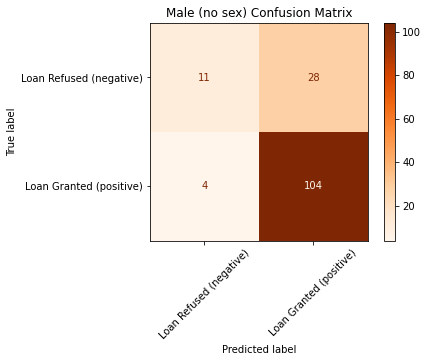

In [28]:
#### START CODE #####

#1. calc confusion matrix
cm = confusion_matrix(male_test_results_nosex[Y], male_test_results_nosex[Y_hat], labels=model_nosex.classes_)

### END CODE ###

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp = disp.plot(cmap='Oranges',values_format = '.0f')
plt.xticks(rotation=45)
plt.title('Male (no sex) Confusion Matrix');
plt.show()

**Your task is to:**

- plot ROC for unaware model for males.

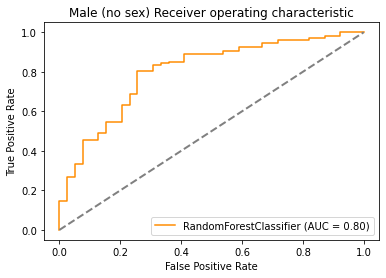

In [29]:
#### START CODE #####

#1. calc roc
metrics.plot_roc_curve(model_nosex, male_X_clean_nosex, male_test_results_nosex[Y], color='darkorange')

### END CODE ###

plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.title('Male (no sex) Receiver operating characteristic')
plt.show()

**Your tasks are to:**

- Calculate and print the accuracy for the unaware model on female data, `female_nosex_acc`
- Calculate and print the f1 score for the unaware model on female data, `female_nosex_f1`


In [30]:
#### START CODE ####

#1. calc acc
female_nosex_accuracy = accuracy_score(female_test_results_nosex[Y], female_test_results_nosex[Y_hat])
print('Model accuracy (females) = ', female_nosex_accuracy)

#2. cacl f1 score
female_nosex_f1 = f1_score(female_test_results_nosex[Y], female_test_results_nosex[Y_hat])
print('Model f1 score (females) = ', female_nosex_f1)

#### END CODE ####

Model accuracy (females) =  0.6792452830188679
Model f1 score (females) =  0.7901234567901234


##### **Expected Output**:

<table>
    <tr>
        <td>
            Model accuracy (females)
        </td>
        <td>
            0.6792452830188679
        </td>
    </tr>    
    <tr>
        <td>
            Model f1 score (females)
        </td>
        <td>
            0.7901234567901234
        </td>
    </tr>
</table> 

**Your task is to:**

- display confusion matrix for unaware model for females.

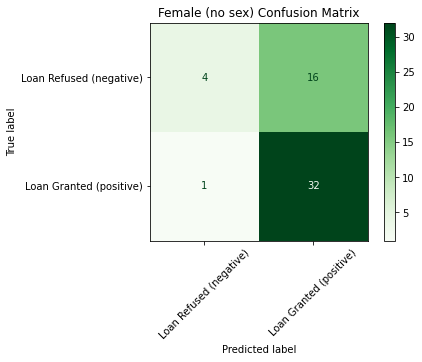

In [31]:
#### START CODE ####

#1. calc confusion matrix
cm = confusion_matrix(female_test_results_nosex[Y], female_test_results_nosex[Y_hat], labels=model_nosex.classes_)

### END CODE ####

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp = disp.plot(cmap='Greens',values_format = '.0f')
plt.xticks(rotation=45)
plt.title('Female (no sex) Confusion Matrix');
plt.show()

**Your task is to:**

- plot the ROC for female data

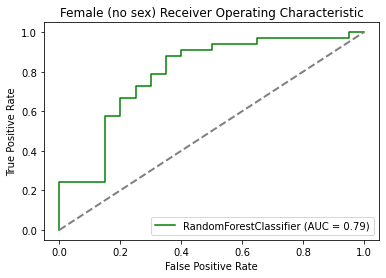

In [32]:
#### START CODE ####

#1. calc ROC
metrics.plot_roc_curve(model_nosex, female_X_clean_nosex, female_test_results_nosex[Y], color='green')

### END CODE #####

plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.title('Female (no sex) Receiver Operating Characteristic')
plt.show() 

## 3.4 Test the Unaware Model for Fairness

In this section you will test the model for fairness under the relaxed conditions of the four-fifths rule.

**Your tasks are to:**

- Calculate demographic parity for positive condition
    - Calculate `Pr_male_nosex_CP` the probability of a Condition Positive for a Male , $Pr(\hat{Y} = 1| A = 1)$
        - Calculate male condition positive count, `male_nosex_CP`
        - Divide by total number of tests, `total_tests`
    - Calculate `Pr_female_nosex_CP` the probability of a Condition Positive for a Female, $Pr(\hat{Y} = 1 | A = 0)$
        - Calculate female condition positive count, `female_nosex_CP`
        - Divide by total number of tests, `total_tests`
- Use your function `Relax_equal` to test for parity under four-fifths rule.

In [33]:
### START CODE ###

#1. calc male CP
male_nosex_CP = len(test_results[(test_results[A] == 1) & (test_results[Y_hat] == 1)])
Pr_male_nosex_CP = male_nosex_CP/total_tests

#2. calc feamle CP
female_nosex_CP = len(test_results[(test_results[A] == 0) & (test_results[Y_hat] == 1)])
Pr_female_nosex_CP = female_nosex_CP/total_tests

#3. calc parity under four-fifths
nosex_demo_parity = Relax_equal(0.2,male_nosex_CP,female_nosex_CP)

### END CODE ####

print('Pr_male_nosex_CP',Pr_male_nosex_CP)
print('Pr_female_nosex_CP',Pr_female_nosex_CP)
print('Demographic Parity =',nosex_demo_parity)

Ratio  0.36363636363636365
Pr_male_nosex_CP 0.66
Pr_female_nosex_CP 0.24
Demographic Parity = False


##### **Expected Output**:

<table>
    <tr>
        <td>
            Ratio
        </td>
        <td>
            0.3636363636363636
        </td>
    </tr>
    <tr>
        <td>
            male_nosex_CP
        </td>
        <td>
            0.66
        </td>
    </tr>    
    <tr>
        <td>
            female_nosex_CP
        </td>
        <td>
            0.24
        </td>
    </tr>
    <tr>
        <td>
            Demographic Parity
        </td>
        <td>
            False
        </td>
    </tr>
</table> 


**Your tasks are to:**

- Calculate equal opportunity
    - Calculate `male_nosex_pos_odds` positive odds for a Male , $Pr(\hat{Y} = 1 | A = 1,Y = 1))$
    - Calculate `female_nosex_pos_odds` positive odds for a Female, $Pr(\hat{Y}= 1 | A = 0,Y = 1)$
- Use your function `Relax_equal()` to test for parity under four-fifths rule.

In [34]:
#### START CODE ####

# calc male pos odds
male_nosex_TP = len(test_results[(test_results[A] == 1) & (test_results[Y] == 1) & (test_results[Y_hat] == 1)])
male_nosex_pos_odds = male_nosex_TP/male_nosex_CP

# calc female pos odds
female_nosex_TP = len(test_results[(test_results[A] == 0) & (test_results[Y] == 1) & (test_results[Y_hat] == 1)])
female_nosex_pos_odds = female_nosex_TP/female_nosex_CP

# test for equal opp under four-fifths
nosex_equal_opp = Relax_equal(0.2,male_nosex_pos_odds,female_nosex_pos_odds)

### END CODE ####

print('male_nosex_pos_odds',male_nosex_pos_odds)
print('female_nosex_pos_odds',female_nosex_pos_odds)
print('Equal Oppertuniy (no sex) =', nosex_equal_opp)

Ratio  0.8461538461538461
male_nosex_pos_odds 0.7878787878787878
female_nosex_pos_odds 0.6666666666666666
Equal Oppertuniy (no sex) = True


##### **Expected Output**:

<table>
    <tr>
        <td>
            Ratio
        </td>
        <td>
            0.8461538461538461
        </td>
    </tr>    
    <tr>
        <td>
            male_nosex_pos_odds
        </td>
        <td>
            0.7878787878787878
        </td>
    </tr>
    <tr>
        <td>
            female_nosex_pos_odds
        </td>
        <td>
            0.6666666666666666
        </td>
    </tr>
    <tr>
        <td>
            Equal Oppertuniy (no sex)
        </td>
        <td>
            True
        </td>
    </tr>
</table> 

### 3.4.1 What changed for the Unaware Model?

In this section list the tests the changed under the unawareness strategy.

**Your tasks are to:**

- list the examples that were classified differently between in the original model and unaware model.
    - view results in the `test_results` dataframe where original mode predictions `pred_Y` are different to unaware model predictions `pred_Y_nosex` (currently `Y_hat`).

In [35]:
#### START CODE ####
print(test_results[test_results['pred_Y'] != test_results[Y_hat]])
#### END CODE ####

     creditamount  duration  installmentrate  residencesince  age  \
17           8072        30                2               3   25   
189          3244        18                1               4   33   
711          1198         6                4               4   35   
597          4241        24                1               4   36   
216          3104        18                3               1   31   
783           836        12                4               2   23   

     existingcredits  peopleliable  existingchecking  credithistory  purpose  \
17                 3             1                 0              0        9   
189                2             1                 1              0        3   
711                1             1                 0              1        7   
597                3             1                 1              0        9   
216                1             1                 0              0        9   
783                1             1  

**Your tasks are to:**

- Of those examples that differ list the ones that are correctly classified under the unawareness model
    - view results in the `test_results` dataframe where original model predictions `pred_Y` are different to unaware model predictions `pred_Y_nosex` (currently `Y_hat`) **and**  `Y_hat` is correct i.e. equal to $Y$, 'classification'.

In [36]:
#### START CODE ####
print(test_results[(test_results['pred_Y'] != test_results[Y_hat]) & (test_results[Y_hat] == test_results['classification'])])
#### END CODE ####

     creditamount  duration  installmentrate  residencesince  age  \
597          4241        24                1               4   36   
216          3104        18                3               1   31   
783           836        12                4               2   23   

     existingcredits  peopleliable  existingchecking  credithistory  purpose  \
597                3             1                 1              0        9   
216                1             1                 0              0        9   
783                1             1                 1              2        0   

     ...  property  otherinstallmentplans  housing  job  telephone  \
597  ...         0                      2        1    1          1   
216  ...         1                      0        1    2          1   
783  ...         1                      0        1    1          0   

     foreignworker  classification  pred_Y  Sex_code  pred_Y_nosex  
597              0               0       1         1

# 4. Critical Analysis, Reflection & Discussion

- From your obervations is demographic parity a fairness standard we should hold finalcial instiutions to when handing out loans?<br>
Yes, I do believe it is something that we should hold finacial institutions to when handing out loans. <br>

- Can you think of a real-world context within which demographic parity should be applied? <br>
A good example would be the issue with gender pay gap. There should be no need to discriminate between employee's because of there gender. Factors like years of service, accomplishments and education should be playing the biggest attributes.

- From your observations comment on the effectiveness of fairness through unawareness in the context of issuing loans. <br>
    - did it make a significnat difference to the perfrmance of the algorithm?<br>
    Model accuracy (males) = 0.7755102040816326 <br>
    Model f1 score (males) = 0.8630705394190872 <br>
    Model accuracy (females) = 0.6981132075471698 <br> 
    Model f1 score (females) = 0.8048780487804877 <br>
    <br>
    After: <br>
    Model accuracy (males) = 0.782312925170068  <br>
    Model f1 score (males) = 0.8666666666666665 <br>
    Model accuracy (females) = 0.6792452830188679 <br> 
    Model f1 score (females) = 0.7901234567901234 <br>
    Therefore we can see that the performance was affect but not by any great deal of significants.
<br>
<br>
    - did it make a significant difference the the fairness of the algorithm? <br>
        Before:<br>
        Male Condition Positive probability =  0.665 <br> 
        Female Condition Positive probability =  0.245 <br>
        Male Condition Negative probability =  0.07 <br>
        Female Condition Negative probability =  0.02 <br>
        Demographic Parity for Condition Positive is: False <br>
        Demographic Parity for Condition Negative is: False <br>
        Demographic Parity is: False <br>
<br>
        After:<br>
        Ratio 0.8461538461538461  <br> 
        male_nosex_pos_odds 0.7878787878787878  <br>
        female_nosex_pos_odds 0.6666666666666666  <br>
        Equal Oppertuniy (no sex) = True <br>
Therefore altering the algorithm for fairness made a big difference as females were then more likely to be accepted for a loan compared to before.
    